# PLQY analysis

In [25]:
#import the necessary libraries for pandas and plotting
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
#import the glob library to retrieve all the files in a folder
import glob
#import the necessary libraries
from scipy.optimize import curve_fit
import math

#declare some variables
line_PEW = 2
line_PLQY = 3


#create a list that contains color names used for plotting


colors_list = ['b', 'g', 'c', 'm', 'y', 'k', 'w', 'r']
colors_list_2 = ["blue", "green", "red", "cyan", "magenta", "yellow", "black", "orange", "purple", "pink", "brown", "gray"]
colors_plqy = ["b", "b", "b", "g", "g", "g", "r", "r", "r", "k", "k", "k", "c", "c", "c", "m", "m", "m", "y", "y", "y", "w", "w", "w"]


name = ["Tricyclo1", "Tricyclo2", "DPPP1", "DPPP2", "Dodecy1", "Dodecy2", "meo4DPPP", "meo2DPPP", "ref1", "ref2"]
numbers = list(range(1, 11))
lut = dict(zip(numbers, name))

#create a function that reads the data from a PLQY file
def read_data(file):
    df = pd.read_csv(file, sep='\s+', skiprows=8, header=None)
    return df


#create a function that opens a file, and returns the last number of the n-line
def get_number_in_line(file, line):
    with open(file) as f:
        for i, l in enumerate(f):
            if i == line:
                return float(l.split()[-1])
            

#create a function that simplifies the file name
def simplify_name(file):
    #split the file name using the "\" as separator
    file_name = file.split('\\')[-1]
    #split the file name using the "_" as separator
    file_name = file_name.split('_')[0]
    #uppercase
    file_name = file_name.upper()

    #if the file_name contains "BAD" then remove it
    if "BAD" in file_name:
        file_name = file_name.replace("BAD", "")

    return file_name


def func(x, a, b, c, d):
    return a * np.exp(-(x - b)**2 / (2 * c**2)) + d


#create a function that finds a gaussian function that fits the data
def gaussian_fitting(data):
    #define the gaussian function


    p_a = max(data[1])


    #set b equals to the x value of the maximum of the data
    p_b = data[0][np.argmax(data[1])]
    #for p_c, use the value of the difference between the values at half the maximum
    #find the index of the value that is closest to half the maximum
    index = (np.abs(data[1] - max(data[1])/2)).argmin()
    #find the value of the x axis at that index
    p_c = abs(data[0][index] - p_b)
    p_d = min(data[1])

    p = [p_a, p_b, p_c, p_d]

    #fit the data with the gaussian function
    popt, pcov = curve_fit(func, data[0], data[1], p0 = p)
    return popt

#create a function that normalizes the data
def normalize_data(data):
    #find the maximum of the data
    max_data = np.max(data[1])
    #normalize the data
    data[1] = data[1] / max_data
    return data


## Plotting PLQY

### Plot PLQY firsts samples

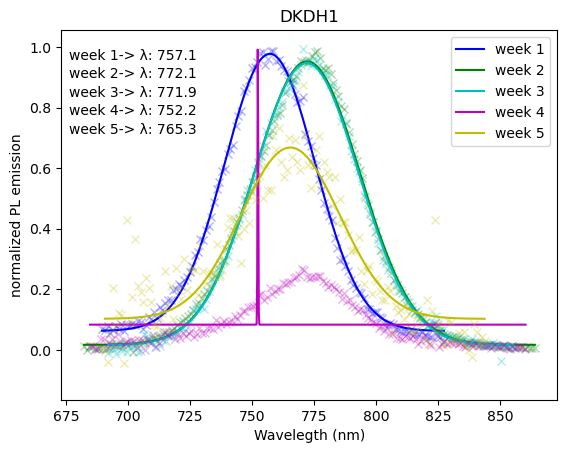

In [10]:
#ask the user the name of the file to display
#sample = input("Which sample would you like to display? ")

sample = "dkdh1"

#put the name in uppercase
sample = sample.upper()

index = 0

for folder in glob.glob("PLQY/*"):
    #for each file in the folder do
    for file in glob.glob(folder + "/*evaluated.dat"):
        name1 = simplify_name(file)
        if name1 == sample:
            #read the file
            df = read_data(file)
            #normalize the data
            df[1] = normalize_data(df)[1]
            popt = gaussian_fitting(df)
            #plot the data using a different color for each file
            plt.plot(df[0], df[1], colors_list[index] + "x", markevery=5, alpha=0.3)
            plt.plot(df[0], func(df[0], *popt), colors_list[index] + "-", label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))
            #add a legend with the index number
            index += 1
            plt.text(0.015, (1-0.05*index), 'week {:d}-> λ: {:.1f} '.format(index, popt[1]), transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
        lgd = []
        for i in range(0, (index)):
            lgd.append("_")
            lgd.append("week " + str(i + 1))
            
        plt.legend(lgd)
        plt.title(sample)
        #add a y label
    
        plt.ylabel("normalized PL emission")
        plt.xlabel("Wavelegth (nm)")
        

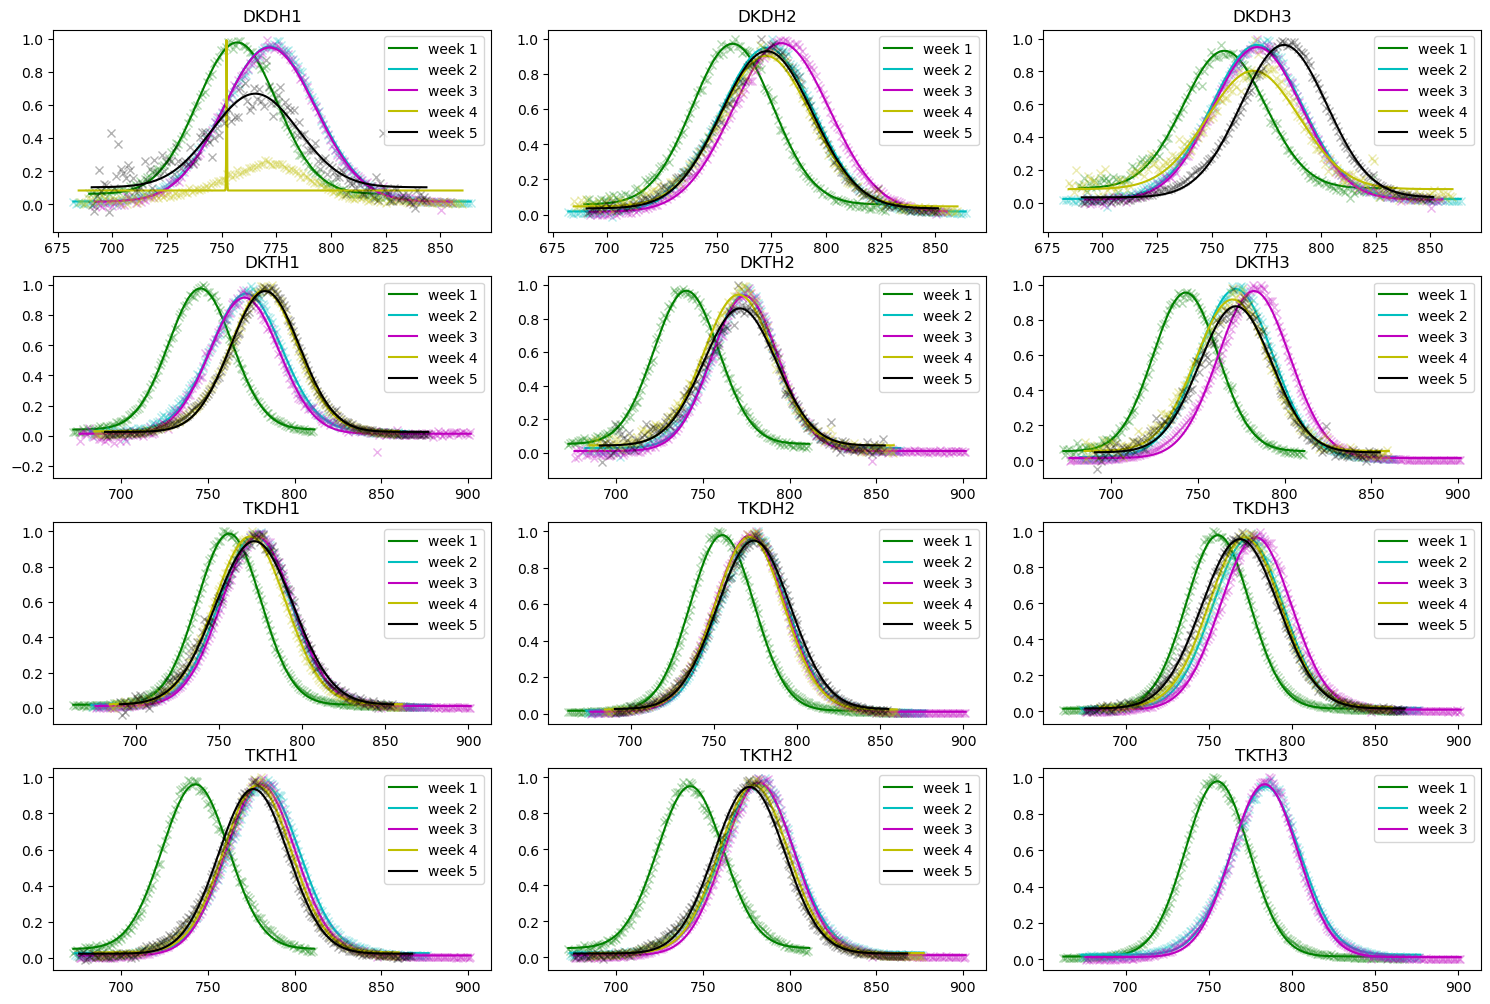

In [11]:
#list the files in the folder
files = glob.glob("PLQY/w1/*_evaluated.dat")
samples = []
for i in range(0, len(files)):
    samples.append(simplify_name(files[i]))

rows = len(samples) // 3
fig, axs = plt.subplots(rows, 3, figsize=(15, 10), sharey=False)
#make sure that the subplots are not overlapping
fig.tight_layout()

max_peak = []

for i in range(0, len(samples)):
    #initialize the figure with len(samples) subplots with 3 columns and x rows
    #for each folder in the PLQY folder do
    index = 0
    lgd = []
    for folder in glob.glob("PLQY/*"):
        #find the file that contains the sample name
        
        for file in glob.glob(folder + "/*evaluated.dat"):
            name1 = simplify_name(file)
            if name1 == samples[i]:
                index += 1
                #read the file
                df = read_data(file)
                #normalize the data
                df[1] = normalize_data(df)[1]
                popt = gaussian_fitting(df)

                #plot the data in a different subplot for each sample
                axs[i // 3, i % 3].plot(df[0], df[1], colors_list[index] + "x", markevery=5, alpha=0.3)
                axs[i // 3, i % 3].plot(df[0], func(df[0], *popt), colors_list[index] + "-")
                #add a legend with the index number
                lgd.append("_")
                lgd.append("week " + str(index))
                axs[i // 3, i % 3].legend(lgd)
                axs[i // 3, i % 3].set_title(samples[i])
                max_peak.append(popt[1])

#complete  the list max_peak so that it is 60 elements long with nan values
max_peak = max_peak + [np.nan] * (60 - len(max_peak))

#create dataframe of size 12*5 filled with nan values
df_peak_pos = pd.DataFrame(np.nan, index=np.arange(5), columns=np.arange(12))

for i in range(0, 12):
    for j in range(0, 5):
        df_peak_pos[i][j] = max_peak[i*5 + j]

#duplicate the dataframe
df_peak_pos2 = df_peak_pos.copy()

#replace the value of each cell with the value of the first cell minus the value of the cell
for i in range(0, 12):
    for j in range(0, 5):
        df_peak_pos2[i][j] = df_peak_pos[i][0] - df_peak_pos[i][j]


#replace df_peak_pos with df_peak_pos2
df_peak_pos = df_peak_pos2

Text(0.5, 1.0, 'Peak position in nm at each week')

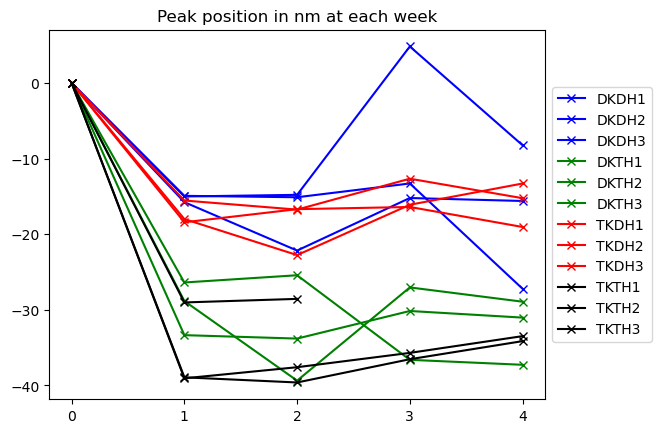

In [12]:
#plot each column of the dataframe 
for i in range(0, len(samples)):
    plt.plot(df_peak_pos.index, df_peak_pos.iloc[:, i], "x-", color=colors_plqy[i])

#add the legend on the right side of the plot
plt.legend(samples, loc='center left', bbox_to_anchor=(1, 0.5))

#set the x-ticks to be intergers
plt.xticks(df_peak_pos.index)

#add a title
plt.title("Peak position in nm at each week")

### Plotting PLQY for the 2nd samples

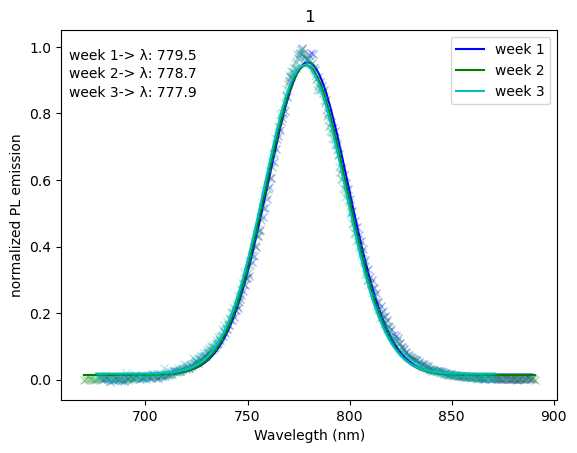

In [33]:
#ask the user the name of the file to display
#sample = input("Which sample would you like to display? ")

sample = "1"

#put the name in uppercase
sample = sample.upper()

index = 0

for folder in glob.glob("PLQY/*"):
    #for each file in the folder do
    for file in glob.glob(folder + "/*evaluated.dat"):
        name1 = simplify_name(file)
        if name1 == sample:
            #read the file
            df = read_data(file)
            #normalize the data
            df[1] = normalize_data(df)[1]
            popt = gaussian_fitting(df)
            #plot the data using a different color for each file
            plt.plot(df[0], df[1], colors_list[index] + "x", markevery=5, alpha=0.3)
            plt.plot(df[0], func(df[0], *popt), colors_list[index] + "-", label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))
            #add a legend with the index number
            index += 1
            plt.text(0.015, (1-0.05*index), 'week {:d}-> λ: {:.1f} '.format(index, popt[1]), transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
        lgd = []
        for i in range(0, (index)):
            lgd.append("_")
            lgd.append("week " + str(i + 1))
            
        plt.legend(lgd)
        plt.title(sample)
        #add a y label
    
        plt.ylabel("normalized PL emission")
        plt.xlabel("Wavelegth (nm)")
        

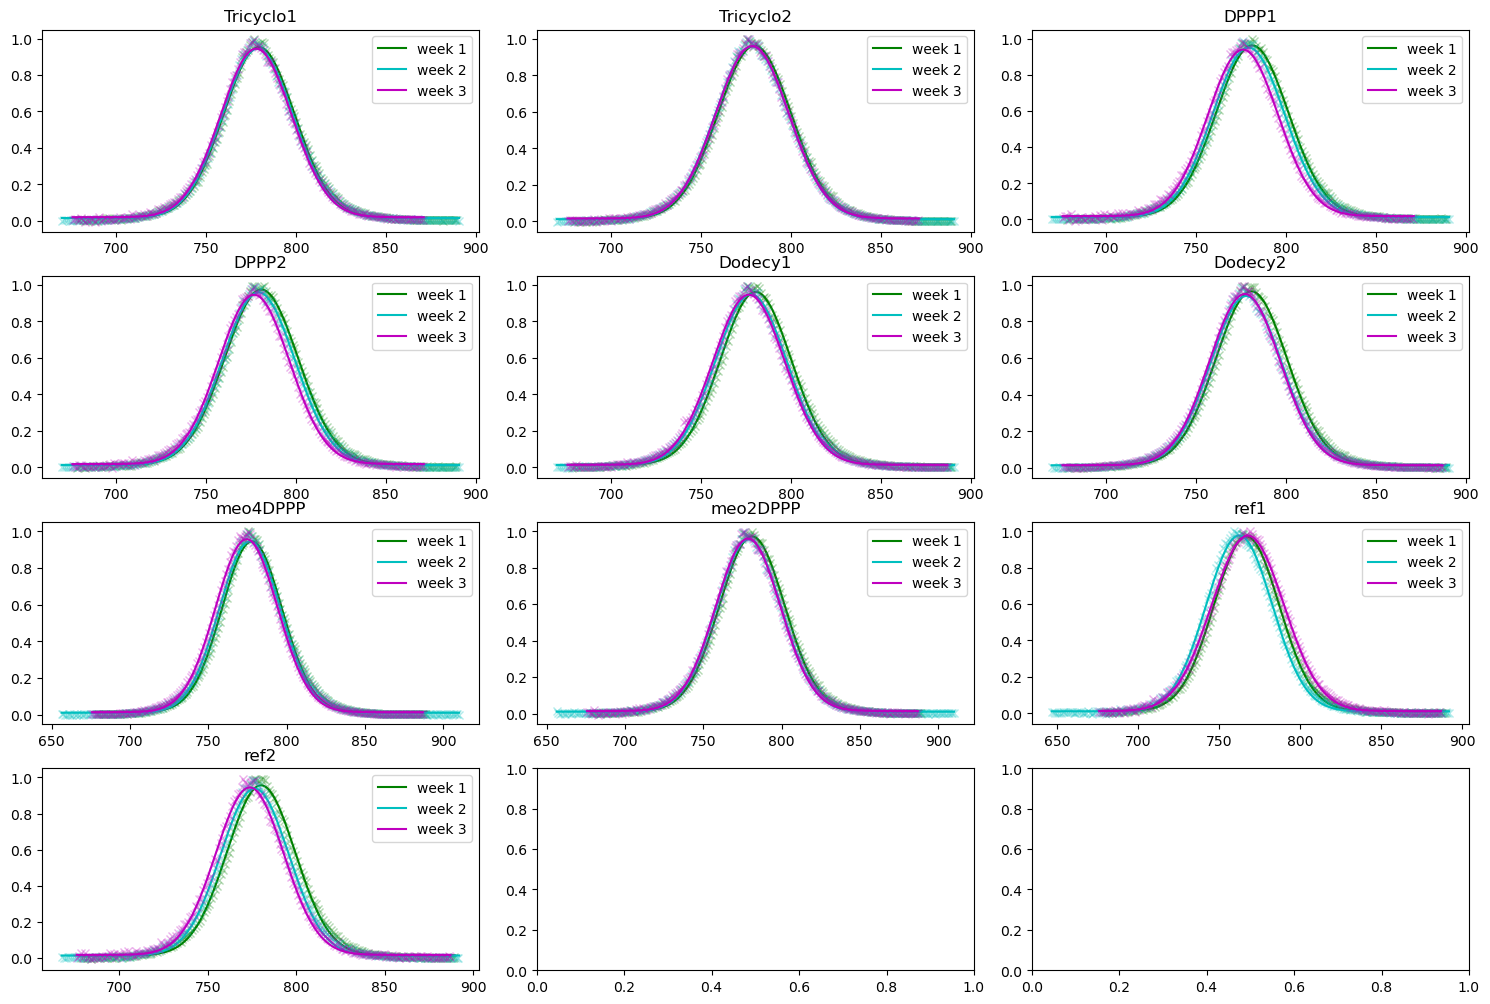

In [24]:
#create a look up table that associate a the numbers from 1 to 10 to the liste name : "Tri1, Tri2, DPPP1, DPPP2, Dodecy1, Dodecy2, meo4DPPP, meo2DPPP, ref1, ref2"
name = ["Tricyclo1", "Tricyclo2", "DPPP1", "DPPP2", "Dodecy1", "Dodecy2", "meo4DPPP", "meo2DPPP", "ref1", "ref2"]
numbers = list(range(1, 11))
lut = dict(zip(numbers, name))

#list the files in the folder
files = glob.glob("PLQY/w4_2/*_evaluated.dat")
samples = []
for i in range(0, len(files)):
    samples.append(simplify_name(files[i]))

#place the first element of the list at the end of the list
samples.append(samples.pop(0))


rows = len(samples) // 3 + 1
fig, axs = plt.subplots(rows, 3, figsize=(15, 10), sharey=False)
fig.tight_layout()

max_peak = []

for i in range(0, len(samples)):
    #initialize the figure with len(samples) subplots with 3 columns and x rows
    #for each folder in the PLQY folder do
    index = 0
    lgd = []
    for folder in glob.glob("PLQY/*"):
        #find the file that contains the sample name
        
        for file in glob.glob(folder + "/*evaluated.dat"):
            name1 = simplify_name(file)
            if name1 == samples[i]:
                index += 1
                #read the file
                df = read_data(file)
                #normalize the data
                df[1] = normalize_data(df)[1]
                popt = gaussian_fitting(df)

                #plot the data in a different subplot for each sample
                axs[i // 3, i % 3].plot(df[0], df[1], colors_list[index] + "x", markevery=5, alpha=0.3)
                axs[i // 3, i % 3].plot(df[0], func(df[0], *popt), colors_list[index] + "-")


                #add a legend with the index number
                lgd.append("_")
                lgd.append("week " + str(index))
                axs[i // 3, i % 3].legend(lgd)
                axs[i // 3, i % 3].set_title(lut[i + 1])
                max_peak.append(popt[1])

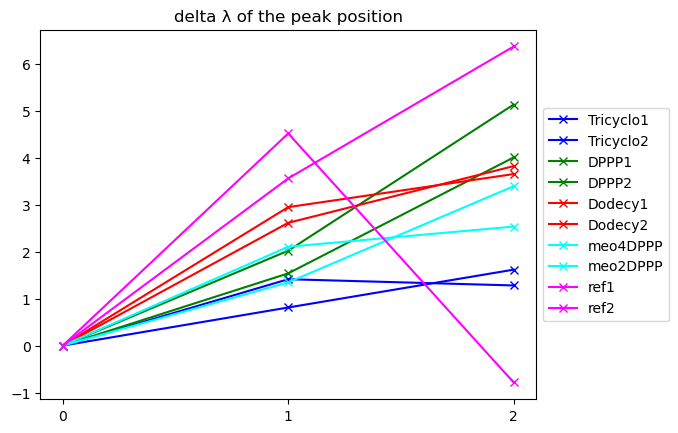

In [40]:
colors_list_3 = ["blue", "blue", "green", "green", "red", "red", "cyan", "cyan", "magenta", "magenta", "yellow", "yellow", "black", "black", "orange", "orange", "purple", "purple", "pink", "pink", "brown", "brown", "gray", "gray"]

#create dataframe of size 12*5 filled with nan values
depth_df = int(len(max_peak) / 10)
df_peak_pos = pd.DataFrame(np.nan, index=np.arange(depth_df), columns=np.arange(10))

for i in range(0, 10):
    for j in range(0, depth_df):
        df_peak_pos[i][j] = max_peak[i*depth_df + j]

#duplicate the dataframe
df_peak_pos2 = df_peak_pos.copy()

#replace the value of each cell with the value of the first cell minus the value of the cell
for i in range(0, 10):
    for j in range(0, depth_df):
        df_peak_pos2[i][j] = df_peak_pos[i][0] - df_peak_pos[i][j]


#replace df_peak_pos with df_peak_pos2
df_peak_pos = df_peak_pos2

#plot each column of the dataframe 
for i in range(0, 10):
    plt.plot(df_peak_pos.index, df_peak_pos[i], "x-", label=samples[i], color = colors_list_3[i])

#add a legend to the right of the plot with the names from the lut dictionary
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), labels=lut.values())

#set the x-ticks to be intergers
plt.xticks(df_peak_pos.index)

#add a title
plt.title("delta λ of the peak position");


## Evolution of PLQY

In [21]:
#create a new dataframe with three columns with the names "sample", "PEW" and "PLQY"
df4 = pd.DataFrame(columns=['sample', 'PEW_1', 'PLQY_1'])

index = 1
#for each folder in the PLQY folder do
for folder in glob.glob("PLQY/*"):
    #if this is the first iteration
    if folder == "PLQY\\w1":
        #for each file in the folder do
        for file in glob.glob(folder + "/*evaluated.dat"):
            #get the simplified name of the file
            name = simplify_name(file)
            #get the number in the 3rd line
            number1 = get_number_in_line(file, line_PEW)
            #get the number in the 4th line
            number2 = get_number_in_line(file, line_PLQY)
            #add a new row to the dataframe with the name of the file, the number in the 3rd line and the number in the 4th line
            df4 = df4.append({'sample': name, 'PEW_1': number1, 'PLQY_1': number2, "Non_rad_loss_1": 25.85e-3*np.log(number2)}, ignore_index=True)
    elif len(folder) == 7:
        df4['PEW_' + str(index)] = 0
        df4['PLQY_' + str(index)] = 0
        #for each file in the folder do
        for file in glob.glob(folder + "/*evaluated.dat"):
            #get the simplified name of the file
            name = simplify_name(file)
            #get the number in the 3rd line
            number1 = get_number_in_line(file, line_PEW)
            #get the number in the 4th line
            number2 = get_number_in_line(file, line_PLQY)
            #fill the new columns with the values of PEW and PLQY starting from the beginning of the dataframe
            df4.loc[df4['sample'] == name, 'PEW_' + str(index)] = number1
            df4.loc[df4['sample'] == name, 'PLQY_' + str(index)] = number2
            df4.loc[df4['sample'] == name, "Non_rad_loss_" + str(index)] = 25.85e-3*np.log(number2)
    index += 1

#replace the zeros with NaN
df4 = df4.replace(0, np.nan)
df4

,sample,PEW_1,PLQY_1,Non_rad_loss_1,PEW_2,PLQY_2,Non_rad_loss_2,PEW_3,PLQY_3,Non_rad_loss_3,PEW_6,PLQY_6,Non_rad_loss_6,PEW_8,PLQY_8,Non_rad_loss_8
0,DKDH1,760.0,0.00417,-0.141654,776,0.00392,-0.143252,770,0.001210,-0.173638,752.0,0.00136,-0.170617,771.0,0.000167,-0.224831
1,DKDH2,758.0,0.00403,-0.142537,775,0.00348,-0.146330,782,0.002400,-0.155935,771.0,0.00294,-0.150689,770.0,0.001140,-0.175178
2,DKDH3,753.0,0.00197,-0.161038,770,0.00216,-0.158658,770,0.001100,-0.176102,771.0,0.00131,-0.171585,787.0,0.002200,-0.158184
3,DKTH1,747.0,0.00998,-0.119095,775,0.00164,-0.165778,771,0.000591,-0.192161,786.0,0.01080,-0.117054,787.0,0.002210,-0.158067
4,DKTH2,742.0,0.00477,-0.138179,776,0.00149,-0.168257,775,0.001220,-0.173425,771.0,0.00228,-0.157261,770.0,0.000312,-0.208674
5,DKTH3,742.0,0.00503,-0.136807,776,0.00648,-0.130259,787,0.008590,-0.122972,771.0,0.00215,-0.158778,771.0,0.000390,-0.202906
6,TKDH1,753.0,0.01910,-0.102316,776,0.00650,-0.130179,775,0.005440,-0.134781,770.0,0.00836,-0.123674,775.0,0.000626,-0.190674
7,TKDH2,753.0,0.03310,-0.088103,776,0.00813,-0.124395,775,0.007980,-0.124877,776.0,0.01630,-0.106414,774.0,0.001770,-0.163806
8,TKDH3,753.0,0.03660,-0.085504,776,0.00469,-0.138616,776,0.004010,-0.142665,775.0,0.01030,-0.118280,770.0,0.001360,-0.170617
9,TKTH1,741.0,0.00814,-0.124363,781,0.00296,-0.150513,781,0.004400,-0.140266,781.0,0.01080,-0.117054,777.0,0.001090,-0.176338


Text(0.5, 1.0, 'Non-radiative loss at each week')

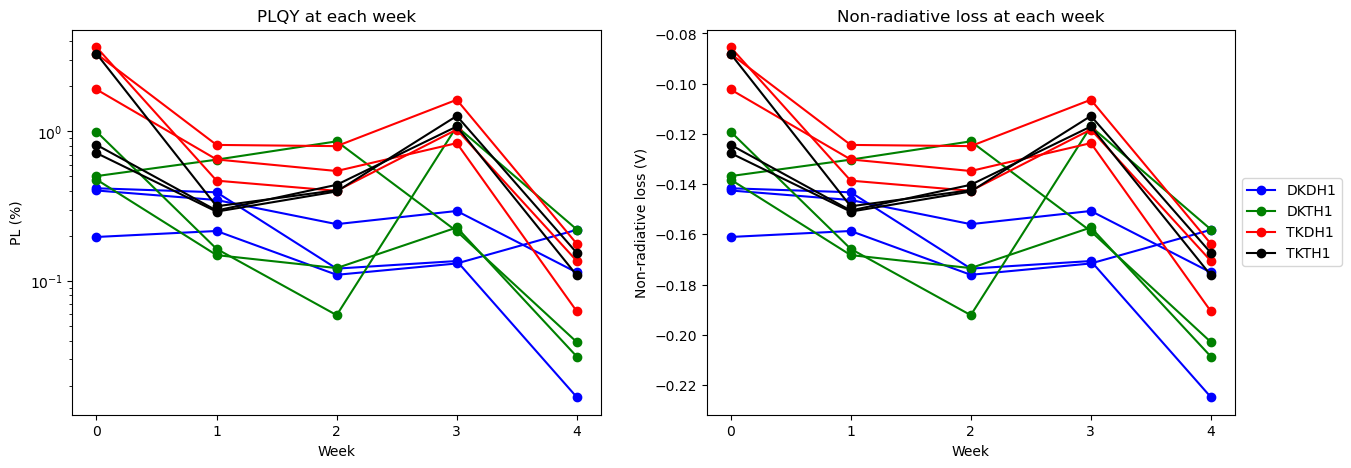

In [19]:
#transpose the dataframe
df5 = df4.transpose()
#use the first row as the header
df5.columns = df5.iloc[0]
#drop the first row
df5 = df5.drop(df5.index[0])
#reset the index
df5 = df5.reset_index()
#rename the index column
df5 = df5.rename(columns={'index': 'sample'})
#set the sample column as the index
df5 = df5.set_index('sample')

#split the dataframe in two dataframes taking one row every two but keep the header
df_pew = df5.iloc[::3, :]
df_plqy = df5.iloc[1::3, :]
df_loss = df5.iloc[2::3, :]

#multiply the values in the dataframe by 100
df_plqy = df_plqy*100

#do a subplot with 2 columns and 1 row. On the first one, plot the plqy and on the second one plot the loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
#plot the plqy using a log scale on the y axis, using the colors in the list colors colors_plqy
for i in range(0, len(df_plqy.columns)):
    ax1.plot(df_plqy.index, df_plqy.iloc[:, i], label=df_plqy.columns[i], marker='o', color=colors_plqy[i])
ax1.set_yscale('log')
#plot the loss
for i in range(0, len(df_loss.columns)):
    ax2.plot(df_loss.index, df_loss.iloc[:, i], label=df_loss.columns[i], marker='o', color=colors_plqy[i])
#ax2.set_yscale('log')

lgd = []
for i in range(0, int(len(df_plqy.columns)), 3):
    lgd.append(df_plqy.columns[i])
    lgd.append("_")
    lgd.append("_")

#add a legend using the list lgd and put it on the left of the plot
ax2.legend(lgd, loc='center left', bbox_to_anchor=(1, 0.5))

#replace the xticks with the a list of numbers starting from 1 and ending at the number of rows in the dataframe 
ax1.set_xticks(range(len(df_plqy.index)))
ax1.set_xticklabels(range(0, len(df_plqy.index)))
ax2.set_xticks(range(len(df_loss.index)))
ax2.set_xticklabels(range(0, len(df_loss.index)))

#add a title to the first subplot
ax1.set_title('PLQY at each week')
#add a y label to the first subplot
ax1.set_ylabel('PL (%)')
#add a y label to the second subplot
ax2.set_ylabel('Non-radiative loss (V)')
#add a x label to the second subplot
ax2.set_xlabel('Week')
ax1.set_xlabel('Week')

#add a title to the second subplot
ax2.set_title('Non-radiative loss at each week')

Text(0.5, 0, 'Week')

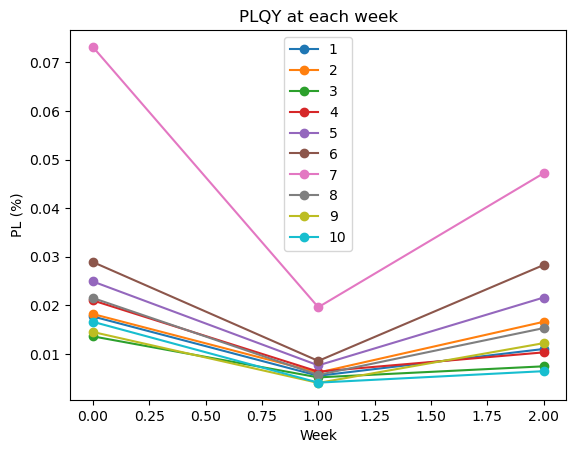

In [38]:
#create a list of the files in the folder PLQY/w4_2
files = glob.glob("PLQY/w4_2/*evaluated.dat")
folders = glob.glob("PLQY/*")
list_of_files = []
#get the simplified name of the first file
for i in range(0, len(files)):
    list_of_files.append(simplify_name(files[i]))
#put the first element at the end of the list
list_of_files.append(list_of_files[0])
list_of_files.pop(0)

#create a dictionary with the simplified name of the file as key
dict_of_files = {}
for i in range(0, len(list_of_files)):
    dict_of_files[list_of_files[i]] = []

for i in range(0, len(files)):
    for j in range(0, len(folders)):
        #make a list of the files in the folder
        files_in_folder = glob.glob(folders[j] + "/*evaluated.dat")
        #for each file in the folder do
        for k in range(0, len(files_in_folder)):
            name = simplify_name(files_in_folder[k])
            if name == list_of_files[i]:
                plqy = get_number_in_line(files_in_folder[k], line_PLQY)
                dict_of_files[name].append(plqy)

#make a dataframe from the dictionary
df_plqy_2samples = pd.DataFrame.from_dict(dict_of_files, orient='index').T

#plot each column of the dataframe
for i in range(0, len(df_plqy_2samples.columns)):
    plt.plot(df_plqy_2samples.index, df_plqy_2samples.iloc[:, i], label=df_plqy_2samples.columns[i], marker='o')
plt.legend()

#add a title to the plot
plt.title('PLQY at each week')  
#add a y label to the plot
plt.ylabel('PL (%)')
#add a x label to the plot
plt.xlabel('Week')